Arden Chaing

Phys 434

November 1st, 2020

Lab 4

In [41]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy.optimize import curve_fit
import h5py
matplotlib.rc('font', size=22)
matplotlib.rc('figure', figsize=(18, 10))

In [42]:
hf = h5py.File('gammaray_lab4.h5', 'r')
data = np.array(hf.get('data'))
hf.close()

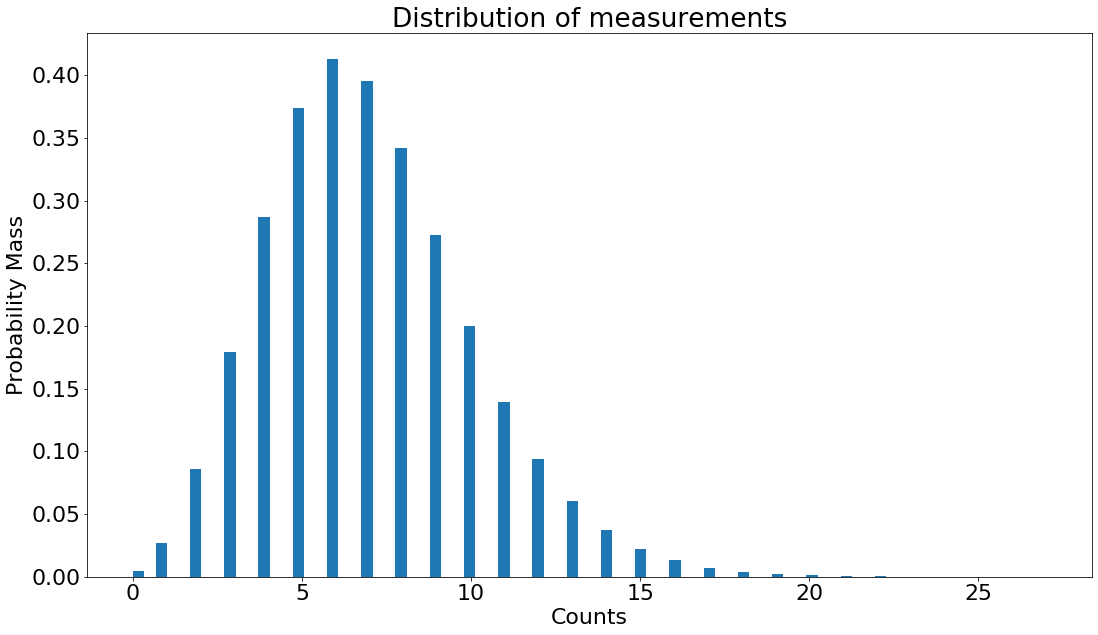

In [43]:
plt.title('Distribution of measurements')
plt.xlabel('Counts')
plt.ylabel('Probability Mass')
plt.hist(data[3][0:400000], bins=80, density=True);
plt.show()

Here I've plotted the first 400k points just to see what our data looks like. This looks like a discrete distribution which makes sense since each measurement represents a # of events seen in a certain time interval. It does look like a poisson distribution, with a mean of 6. But is it really poisson? We can figure that out by plotting on a log scale with an actually poisson distribution.

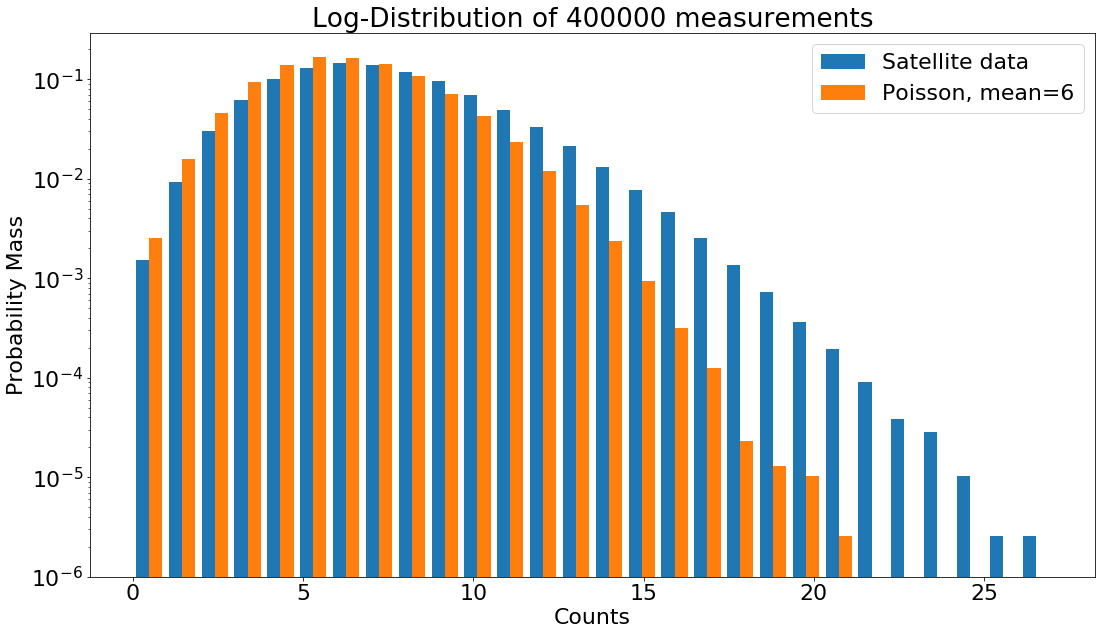

In [44]:
plt.title("Log-Distribution of 400000 measurements")
plt.xlabel('Counts')
plt.ylabel('Probability Mass')
dist = stats.poisson(6)
vals = dist.rvs(400000)
plt.hist([data[3][0:400000], vals], bins=28, density=True)
plt.yscale('log')
plt.ylim(1e-6, None)
plt.legend(['Satellite data', 'Poisson, mean=6']);
plt.show()

It's not exactly a poisson distribution with a mean of 6 if we look at the differences on the right rail. So there seems to be some signal contamination. To find out the source of the containmination is to plot the metadata with the raw data. 

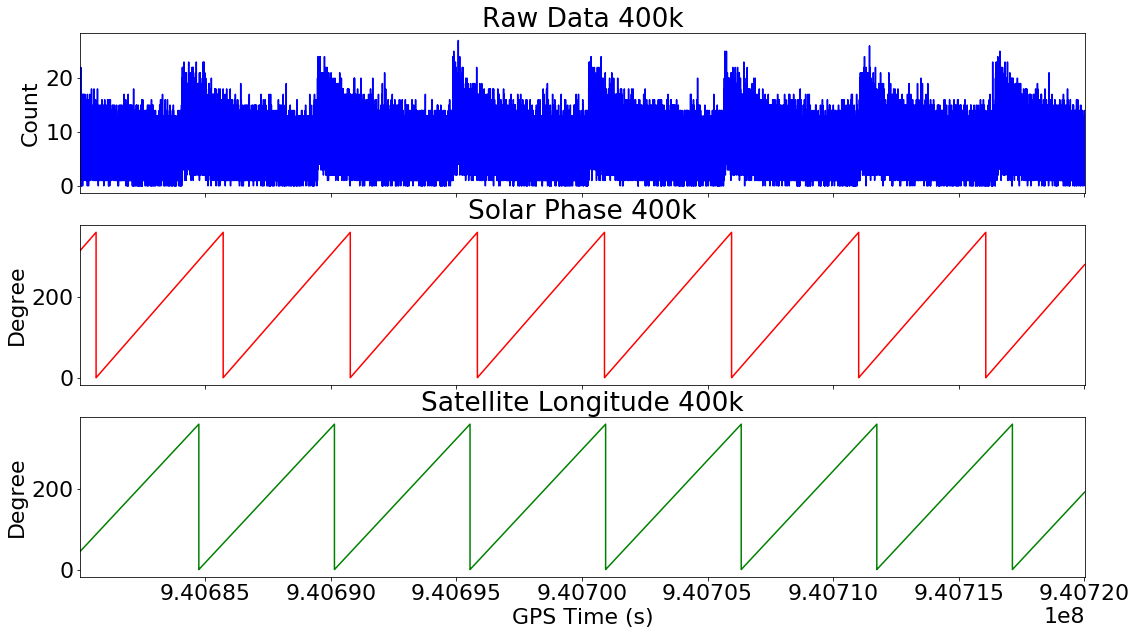

In [45]:
fig,ax = plt.subplots(3,1,figsize=(18, 10), sharex = True)
ax[0].set_title("Raw Data 400k")
ax[0].set_ylabel("Count")
ax[0].plot(data[0][0:400000], data[3][0:400000], color = 'b')
ax[0].set_xlim(data[0][0], data[0][400000])
ax[1].set_title("Solar Phase 400k")
ax[1].set_ylabel("Degree")
ax[1].plot(data[0][0:400000], data[1][0:400000], color = 'r')
ax[1].set_xlim(data[0][0], data[0][400000])
ax[2].set_title("Satellite Longitude 400k")
ax[2].set_ylabel("Degree")
ax[2].set_xlabel("GPS Time (s)")
ax[2].plot(data[0][0:400000], data[2][0:400000], color = 'g')
ax[2].set_xlim(data[0][0], data[0][400000])
plt.show()

Above we can see that the raw data has a cyclic dependency with time. And it appears that the solar phase doesn't have a relationship with the raw data, however the longitude lines up well with the periodic spikes in the data. Therefore there is some location-related issue that is causing the spikes in the raw data.

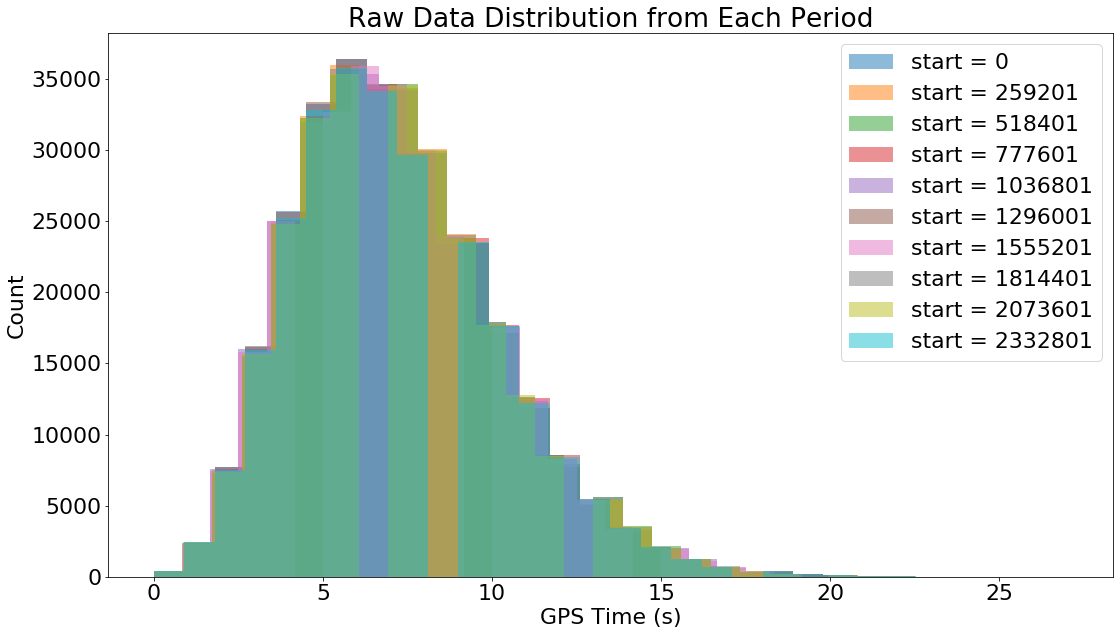

In [46]:
counts = data[3,:]
counts_length = len(counts)
stops = []
for i in range(10):
    stops.append(int((i + 1) * (counts_length / 100)))
for i in range(len(stops)):
    if i == 0:
        start = 0
    else:
        start = stops[i - 1] + 1
    stop = stops[i]
    plt.hist(counts[start:stop], 30, alpha=0.5, label='start = ' + str(start))
plt.title("Raw Data Distribution from Each Period")
plt.xlabel("GPS Time (s)")
plt.ylabel("Count")
plt.legend(loc='best')
plt.show()

Above we have the distribution of the data set in each period to display that its distribution doesn't remain constant. Overall a period lasts aout 40,000 seconds which relates to an orbit of 90 minutes. We can average the all the full periods from the entire data set to get an average period which can we can then fit a function to and find a good approximation of the background over one period of counts. By averaging, if a signal is produced only in a small handfull of periods it's contribution will be scaled to however many periods it appeared in over all the periods which for a large number of periods will almost be zero. Whereas if a signal comes through for every period it is most likely caused by the background and it's contribution will be scaled to about it's original value. This leaves us with an approximation of the background signal.

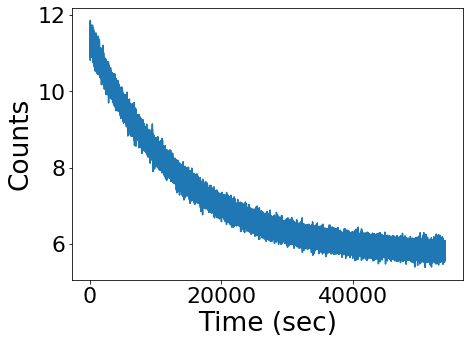

In [47]:
counts = counts[40500:]
period = 54000
counts_parts = []
average_counts = []
for i in range(400):
    start = i * period
    stop = (i + 1) * period
    counts_parts.append(np.array(counts[start:stop]))
    average_counts.append(np.true_divide(np.sum(counts[start:stop]), len(counts[start:stop])))
averaged_data = np.zeros(54000)
total_parts = len(counts_parts)
for part in counts_parts:
    averaged_data = np.add(averaged_data, part)
averaged_data = np.true_divide(averaged_data, total_parts)
time_for_average = np.arange(0, period)
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.plot(time_for_average, averaged_data)
ax.set_xlabel('Time (sec)', fontsize='large')
ax.set_ylabel('Counts', fontsize='large')
plt.show()

The plot above shows the averaged period which I am going to fit a function to that I will use as my background. By averaging all the periods together the overall noise has been greatly reduced. The overall trend of the curve appears to be a decaying exponential $N(t)=a\,e^{-b t}+c$. The only problem is that the time scale is so large that computers can't handle that many figures.

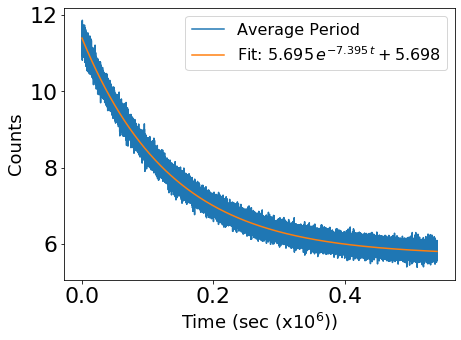

In [48]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c
reduced_time = np.linspace(0, period / 100000, period)
popt, pcov = curve_fit(func, reduced_time, averaged_data)
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.plot(reduced_time, averaged_data, label='Average Period')
ax.plot(reduced_time, func(reduced_time, *popt), label='Fit: $%5.3f\,e^{-%5.3f\,t} + %5.3f$' % tuple(popt))
ax.set_xlabel('Time (sec (x$10^{6}$))', fontsize=18)
ax.set_ylabel('Counts', fontsize=18)
ax.legend(loc='best', fontsize=16)
plt.show()

In order to properly fit a decaying exponential to the curve I scaled the time scale by a factor of $10^6$ which corresponds to 1 for every 100 milliseconds. I then used scypy.optimize, which has a curve fitting function, to fit a function of $N(t)=a\,e^{-b t}+c$. The orange line is my fit and represents the background signal over one period. The line falls nicely in the middle of the noise of the averaged period so it makes a good approximation of the background.

In [49]:
prob = stats.norm.cdf(5)
signal1 = stats.poisson.ppf(prob, average_counts[1])
signal2 = stats.poisson.ppf(prob, average_counts[27])
signal3 = stats.poisson.ppf(prob, average_counts[299])

print('Average number of counts for 2nd period =', average_counts[1])
print('Average number of counts for 28th period =', average_counts[27])
print('Average number of counts for 300th period =', average_counts[299])
print()
print('5\u03C3 for 2nd Period = %5.2f gamma rays' % signal1)
print('5\u03C3 for 28th Period = %5.2f gamma rays' % signal2)
print('5\u03C3 for 300th Period = %5.2f gamma rays' % signal3)

Average number of counts for 2nd period = 7.124314814814815
Average number of counts for 28th period = 7.087018518518518
Average number of counts for 300th period = 7.0979074074074076

5σ for 2nd Period = 24.00 gamma rays
5σ for 28th Period = 24.00 gamma rays
5σ for 300th Period = 24.00 gamma rays


For the 2nd period of counts the number of gamma rays needed to have a measurement of 5$\sigma$ significance is 24. This is the same for the 28th period of counts and the 300th period of counts. I thought this was suspisious so I printed out the average number of counts per period, which corresponds to the shape factor in Poisson pmf, and they were not all the same so I believe that the number of decimals the number of rays goes out to must be very insignificant.

In [50]:
with h5py.File('images.h5', 'r') as hf:
    img_data = np.array(hf.get('imagestack'))

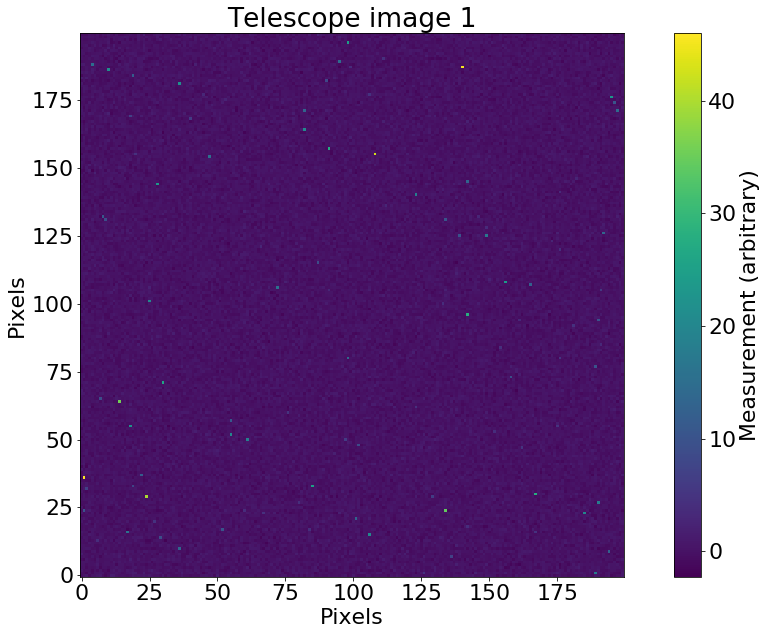

In [51]:
plt.title('Telescope image 1')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.imshow(img_data[:, :, 0], origin='lower')
cbar = plt.colorbar()
cbar.set_label('Measurement (arbitrary)')

We have a stack of ten images from a telescope, displaying one region of the night sky. Our goal is to find measurements of the very faintest stars among the background. Above I plotted one image to see how distributed it is. Which is the sum of the measurements per columnn and row. 

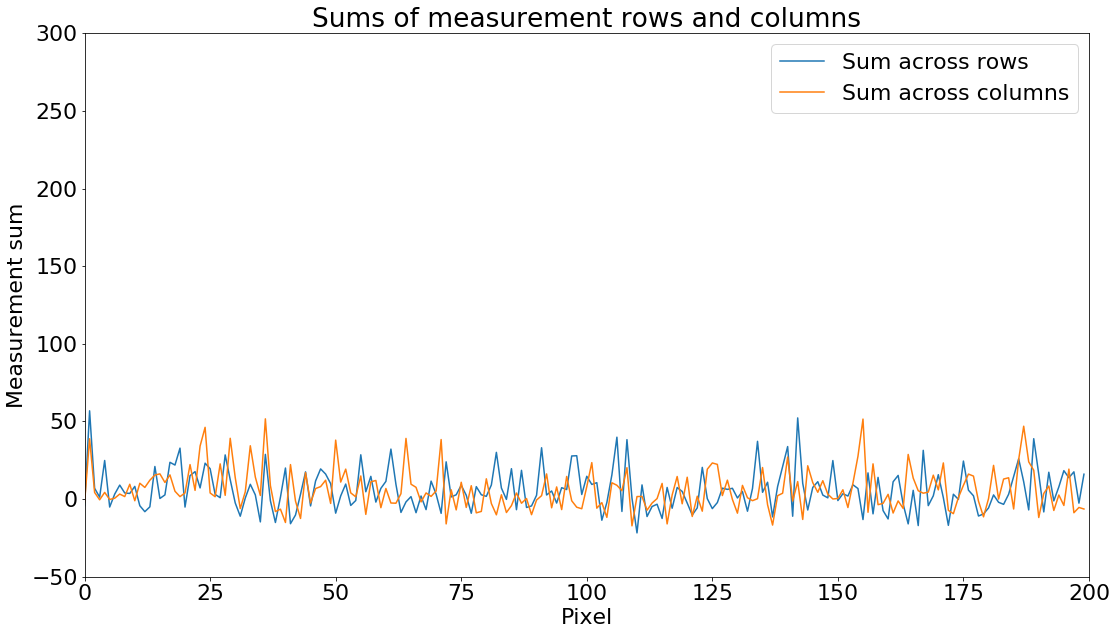

In [52]:
rows_sum = np.sum(img_data[:, :, 0], 0)
cols_sum = np.sum(img_data[:, :, 0], 1)
plt.title('Sums of measurement rows and columns')
plt.xlabel('Pixel')
plt.ylabel('Measurement sum')
plt.plot(np.arange(0, 200), rows_sum)
plt.plot(np.arange(0, 200), cols_sum)
plt.xlim(0, 200)
plt.ylim(-50, 300)
plt.legend(['Sum across rows', 'Sum across columns']);

The data for image 1 appears to be relatively evenly distributed, spatially speaking, given that the sum of measurements along each dimension of the image results in an approximately constant line of noise. Let's plot the 1-dimensional distribution of all the data in the image:

Mean -0.003167586768696385, Std dev 0.5616091705025514


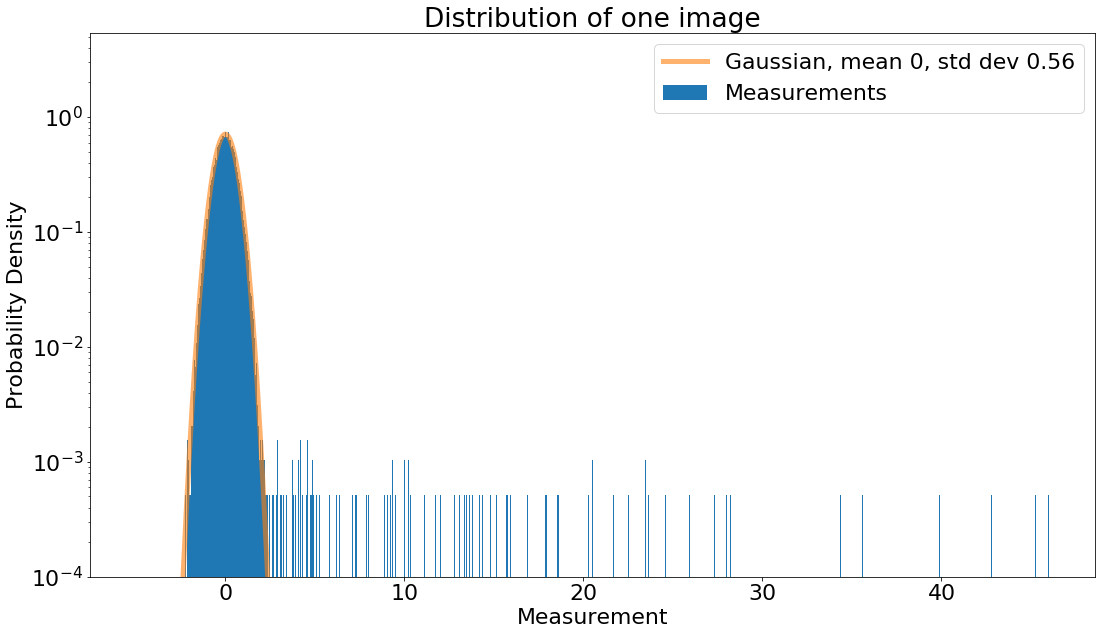

In [53]:
plt.title('Distribution of one image')
plt.xlabel('Measurement')
plt.ylabel('Probability Density')
image1_measurements = img_data[:, :, 0].flatten()
plt.hist(image1_measurements, bins=1000, density=True)
relevant_data_1 = image1_measurements[image1_measurements < 2]
mean = np.mean(relevant_data_1)
std_dev = np.std(relevant_data_1)
print(f"Mean {mean}, Std dev {std_dev}")
x = np.linspace(-5, 5, 1000)
y = stats.norm(mean, std_dev).pdf(x)
plt.plot(x, y, linewidth=5, alpha=0.6)
plt.yscale('log')
plt.ylim(1e-4, None)
plt.legend([f"Gaussian, mean 0, std dev {std_dev.round(2)}", 'Measurements']);

There is some signal contamination from the stars seen in the image, which is indicated by the occasional increase in probability of measurements out to 50 units or so, but for the most part, the background appears to be Gaussian distributed with a mean of about 0 units and a width of about 0.56 units. The distribution of this image is not time-dependent since all the pixels were captured at the same time. It is unknown whether the distribution of all ten images is time-dependent, since there was no information given as to the time difference between images. We will assume that the ten images were taken back-to-back in a very small amount of time, which is reasonable given the power of today's telescopes. 0.56 units is a relatively large width if we're searching for very faint signals, so we need a way to reduce the width of the background. We can do this by averaging the distributions of all ten images together. 

Mean -0.0001292660742716416, Std dev 0.1778348962220202


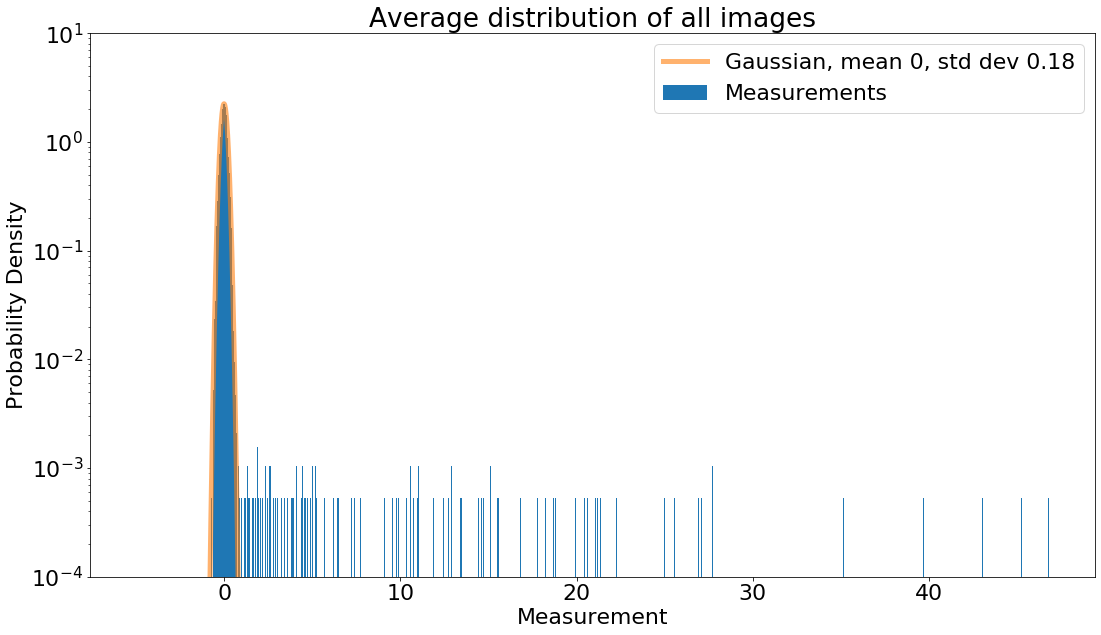

In [54]:
plt.title('Average distribution of all images')
plt.xlabel('Measurement')
plt.ylabel('Probability Density')
average_img = np.mean(img_data, axis=2)
plt.hist(average_img.flatten(), bins=1000, density=True)
relevant_data_avg = average_img[average_img < 1]
mean = np.mean(relevant_data_avg)
std_dev = np.std(relevant_data_avg)
print(f"Mean {mean}, Std dev {std_dev}")
x = np.linspace(-5, 5, 1000)
y = stats.norm(mean, std_dev).pdf(x)
plt.plot(x, y, linewidth=5, alpha=0.6)
plt.yscale('log')
plt.ylim(1e-4, 10)
plt.legend([f"Gaussian, mean 0, std dev {std_dev.round(2)}", 'Measurements']);

The mean of the background distribution remains at 0, but our width has decreased by a factor of 3. If we now calculate the threshold for $5\sigma$ measurements in this distribution, we get:

In [55]:
threshold = stats.norm(mean, std_dev).ppf(stats.norm.cdf(5))
print(threshold)

0.8890452150305256


This answers the question "What signal threshold do I need to be confident that the average background of 10 telescope images did not give me a significant signal?" This means that single measurements of 0.889 could be background measurements, but an average measurement of 0.889 for 10 images is likely not background.Because there is no upper limit on significant measurements, and there are lots of bright stars, we need to restrict the upper bound of the signals we're searching for until we get a satisfactory number of detections. In other words, detecting every star in the night sky is not useful, so to detect only the faintest ones we will restrict our search window to signals that are only slightly above 0.889 units.

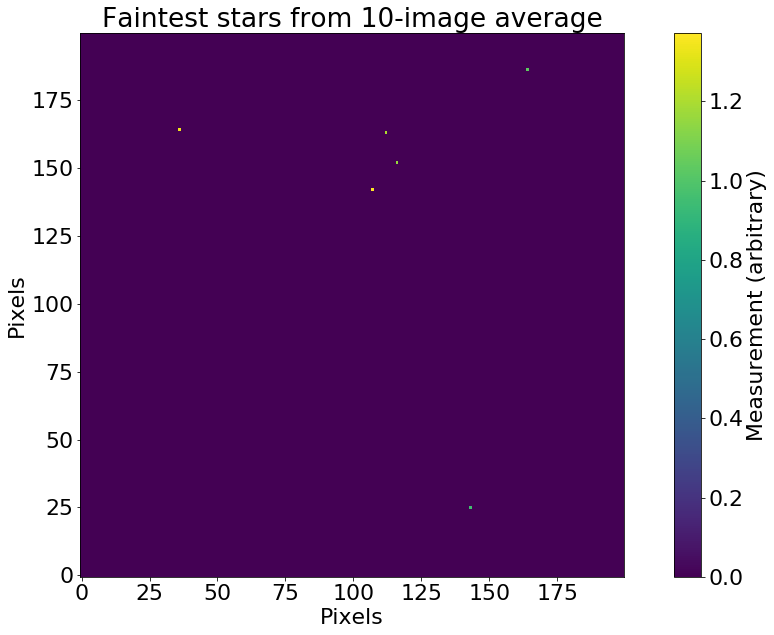

In [56]:
delta = 0.5
detections = (average_img > threshold) & (average_img < threshold + delta)
plt.title('Faintest stars from 10-image average')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.imshow(average_img * detections, origin='lower')
cbar = plt.colorbar()
cbar.set_label('Measurement (arbitrary)')

Above are the locations and brightnesses of the 6 faintest stars seen in this region of the sky, the faintest being located at aroud (145, 25) pixels.While I searched for the faintest stars, my partner searched for bright transient events, like a supernova that would only occur in one image. Because he was concerned with the differences between images, his PDF was different from the background for a single image, since the background for the sum or difference of two images will have a larger standard deviation, equal to $\sigma_k = \sqrt{\sigma_i^2 + \sigma_j^2}$. Thus, his $5\sigma$ threshold will be larger, since the value of $\sigma$ is larger.